## Dataset preprocessing

### downloading images

In [2]:
import urllib.request
import os
from sklearn.model_selection import train_test_split
import torchvision
from torchvision.io.image import read_image
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets, models, transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import shutil

In [3]:
# Names of classes in yoga-82 text files
class_names_82 = [
    "Child_Pose_or_Balasana_",
    "Warrior_II_Pose_or_Virabhadrasana_II_",
    "Standing_Split_pose_or_Urdhva_Prasarita_Eka_Padasana_",
    "Downward-Facing_Dog_pose_or_Adho_Mukha_Svanasana_",
    "Dolphin_Pose_or_Ardha_Pincha_Mayurasana_",
    "Cobra_Pose_or_Bhujangasana_",
    "Tree_Pose_or_Vrksasana_",
    "Cow_Face_Pose_or_Gomukhasana_",
    "viparita_virabhadrasana_or_reverse_warrior_pose"
    
]

# Names of classes in my dataset
class_names = [
    "Child",
    "Warrior_II",
    "Standing_Split",
    "Downward_dog",
    "Dolphin",
    "Cobra",
    "Tree",
    "Cow_Face",
    "Reverse_Warrior"
]

Yoga_82_path = "../yoga-82/yoga_dataset_links/"
data_dir = "../dataset/"
intermediary_path = ""
train_path = data_dir + "Train/"
test_path = data_dir + "Test/"
val_path = data_dir + "Validation/"

In [4]:
def DowloadData():
    try:
        os.mkdir(data_dir)
    except:
        pass

    for split_path in [train_path, test_path, val_path]:
        try:
            os.mkdir(split_path)
        except:
            continue
        for class_name in class_names:
            try:
                os.mkdir(split_path+class_name)
            except:
                pass

    

    if __name__ == "__main__":
        for i in range(len(class_names_82)):
            counter = 0
            class_name = class_names[i]
            name_82 = class_names_82[i]
            intermediary_file_name = intermediary_path + class_name
            try:
                os.mkdir(intermediary_file_name)
            except:
                pass

            url_file = Yoga_82_path + "/" + name_82 + ".txt"
            filenames = os.listdir(os.getcwd() + "/" + class_name)
            with open(url_file) as f:
                d = f.readline()
                while d:
                    url = d.split('\t')[1].strip('\n')
                    filename = class_name + '_' + str(counter) + ".jpg"
                    try:
                        urllib.request.urlretrieve(url, intermediary_file_name + "/" + filename)
                        filenames.append(filename)
                    except:
                        pass
                    counter += 1
                    d = f.readline()

            print("Read " + str(counter) + " files\n")

        # Randomly split dataset into train, test and validation using 60-20-20 split
            train_val, test = train_test_split(filenames, test_size=0.2, train_size=0.8)
            train, val = train_test_split(train_val, test_size=0.25, train_size=0.75)

        # Move data from intermediary file to dataset dir
            for filename in train:
                os.replace(intermediary_file_name + "/" + filename, data_dir + "Train/" + class_name + "/" + filename)
    
            for filename in test:
                os.replace(intermediary_file_name + "/" + filename, data_dir + "Test/" + class_name + "/" + filename)

            for filename in val:
                os.replace(intermediary_file_name + "/" + filename, data_dir + "Validation/" + class_name + "/" + filename)
        
            print("Finished reading files for: ", class_name)
    
        shutil.rmtree(intermediary_file_name)

#DowloadData()
        

### Preparing images

The input to the model is expected to be a list of tensors, each of 
- shape [C, H, W], one for each image 
- Intensity range 0-1. 
- Different images can have different sizes.   

The model returns a Dict[Tensor] during training, containing the classification and regression losses for both the RPN and the R-CNN, and the keypoint loss.

During inference, the model requires only the input tensors, and returns the post-processed predictions as a List[Dict[Tensor]], one for each input image. The fields of the Dict are as follows, where N is the number of detected instances:

boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.

labels (Int64Tensor[N]): the predicted labels for each instance

scores (Tensor[N]): the scores or each instance

keypoints (FloatTensor[N, K, 3]): the locations of the predicted keypoints, in [x, y, v] format.

Images can be correctly formatted by using the transform that is included with the model weights

In [5]:
weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
img_to_ipt = weights.transforms()

### Data augmentation (setting up data loaders)
We apply data augmentation to the training set and use the default transformer for the test and validation set

In [6]:
# Data augmentation and img preprocessing
data_transforms = {
    'Train': transforms.Compose([
        img_to_ipt,
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(0.5), 
        transforms.ColorJitter(brightness=0.1),
        transforms.RandomRotation(degrees=10),
        #transforms.ToTensor(),
    ]),
    'Validation': img_to_ipt,
    'Test': img_to_ipt
}

Using the defined transformers, we can load the training, validation and test dataset into dataloader objects

In [7]:
dset_labels = ['Train', 'Validation', 'Test']

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in dset_labels}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in dset_labels}
dataset_sizes = {x: len(image_datasets[x]) for x in dset_labels}
class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

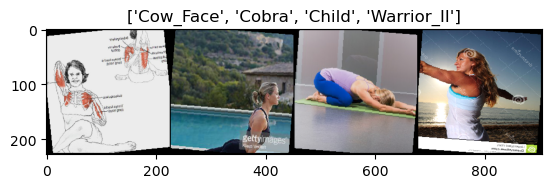

In [8]:
def imshow(inp: torch.Tensor, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

inputs, classes = next(iter(dataloaders['Train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Model

https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.keypointrcnn_resnet50_fpn.html#torchvision.models.detection.keypointrcnn_resnet50_fpn
https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py

In [9]:
plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

img = read_image("child.jpg")

# Step 1: Initialize model with the best available weights
weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()
img_float = transforms(img)
model = keypointrcnn_resnet50_fpn(weights=weights, progress=False)
model.eval()

predictions = model(train_loader)

# # Step 2: Initialize the inference transforms
# preprocess = weights.transforms()

# # Step 3: Apply inference preprocessing transforms
# batch = [preprocess(img)]

# # Step 4: Use the model and visualize the prediction
# prediction = model(batch)[0]
# labels = [weights.meta["categories"][i] for i in prediction["labels"]]
# box = draw_bounding_boxes(img, boxes=prediction["boxes"],
#                           labels=labels,
#                           colors="red",
#                           width=4, font_size=30)
# im = to_pil_image(box.detach())
# im.show()

RuntimeError: [Errno 2] No such file or directory: 'child.jpg'

In [ ]:
weights.meta["keypoint_names"]

In [ ]:
kpts = predictions[0]['keypoints']
scores = predictions[0]['scores']

print(kpts)
print(scores)

In [ ]:
detect_threshold = 0.85
idx = torch.where(scores > detect_threshold)
keypoints = kpts[idx]

print(keypoints)

In [ ]:
res = draw_keypoints(img, keypoints, colors="blue", radius=3)
show(res)

In [ ]:
keypoints.shape